## Importing Required Libraries

This section imports the necessary libraries and modules used for building, training, and evaluating a convolutional neural network (CNN) for image classification.

### Libraries and Modules

- **os**  
  - Provides utilities for interacting with the operating system.  
  - Used here to manage file and directory paths for dataset organization.  

- **NumPy (`np`)**  
  - Core library for numerical operations and array handling.  
  - Supports efficient storage and manipulation of image data and predictions.  

- **Matplotlib (`plt`) & Seaborn (`sns`)**  
  - Libraries for visualization.  
  - Matplotlib: used to plot training/validation accuracy and loss curves.  
  - Seaborn: used for generating heatmaps, such as the confusion matrix.  

- **TensorFlow / Keras**  
  - Provides the deep learning framework for model creation, training, and deployment.  
  - **layers, models**: Building blocks for defining neural networks.  
  - **MobileNetV2**: A lightweight pre-trained CNN architecture used for transfer learning.  
  - **preprocess_input**: Preprocessing function that normalizes images to match MobileNetV2’s expected input.  
  - **EarlyStopping**: A callback that halts training early if validation loss does not improve, preventing overfitting.  

- **scikit-learn (`sklearn.metrics`)**  
  - Provides tools for model evaluation.  
  - **classification_report**: Summarizes model performance with precision, recall, F1-score, and accuracy.  
  - **confusion_matrix**: Produces a matrix to visualize prediction errors across classes.  


In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix


## Verifying TensorFlow Environment

Before building and training the model, it is important to confirm that the environment is correctly set up.


In [2]:
print(tf.config.list_physical_devices("GPU"))
print(tf.__version__)
print(tf.keras.__version__)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
2.10.0
2.10.0


## Dataset Preparation

This section defines the dataset paths, sets key parameters, and loads the image datasets into TensorFlow objects for training, validation, and testing.

### Components

- **Paths**  
  - `data_dir`: Base directory containing the dataset.  
  - `train_dir`, `val_dir`, `test_dir`: Subdirectories for training, validation, and testing data.  
  - Each folder is expected to contain class-specific subfolders (e.g., `Healthy`, `Anthracnose`, etc.).  

- **Parameters**  
  - `img_size = (224, 224)`: Target image size to match MobileNetV2’s required input dimensions.  
  - `batch_size = 32`: Number of images processed per batch during training and evaluation.  

- **Dataset Loading**  
  - Uses `tf.keras.utils.image_dataset_from_directory` to load images from directories.  
  - Automatically labels images based on folder names.  
  - Datasets created:  
    - `train_ds`: Training dataset.  
    - `val_ds`: Validation dataset (used for tuning and preventing overfitting).  
    - `test_ds`: Testing dataset (used for final evaluation).  


In [3]:
# Paths
data_dir = r"C:\Users\Jaero\Desktop\DP1\Group_2_Repo\Plant_Disease_Prediction\data"
train_dir = os.path.join(data_dir, "train")
val_dir = os.path.join(data_dir, "valid")
test_dir = os.path.join(data_dir, "test")

# Parameters
img_size = (224, 224)   # MobileNetV2 input size
batch_size = 32

# Load datasets
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=img_size,
    batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    image_size=img_size,
    batch_size=batch_size
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=img_size,
    batch_size=batch_size
)

Found 1050 files belonging to 3 classes.
Found 300 files belonging to 3 classes.
Found 148 files belonging to 3 classes.


## Class Names Extraction

This section retrieves and displays the **class labels** from the training dataset.  

- `train_ds.class_names`  
  - Automatically extracts class names based on the subdirectory structure of the training folder.  
  - For example, if the training folder contains subfolders named `Healthy`, `Anthracnose`, and `OtherDisease`, these will be returned as the class labels.  



In [3]:
class_names = train_ds.class_names
print("Classes:", class_names)

Classes: ['Anthracnose', 'Healthy', 'OtherDisease']


## Data Preprocessing and Augmentation

This section prepares the input images before feeding them into the MobileNetV2 model.  
It includes **preprocessing** (to match the model’s input requirements) and **data augmentation** (to improve generalization).

### Components

- **Preprocessing Function**
  - `preprocess_input`: Normalizes pixel values into the range expected by MobileNetV2.  
  - `def preprocess(images, labels)`: Applies this normalization to each batch of images while keeping the labels unchanged.  

- **Data Augmentation**
  - Implemented using a `tf.keras.Sequential` pipeline of transformations:
    - `RandomRotation(0.1)`: Rotates images randomly by up to 10%.  
    - `RandomFlip("horizontal")`: Flips images horizontally at random.  
    - `RandomZoom(0.1)`: Zooms into images randomly by up to 10%.  
    - `RandomBrightness(factor=0.2)`: Adjusts image brightness by up to ±20%.  
  - Augmentation helps prevent overfitting by providing varied versions of the training data.

- **Applying Transformations**
  - `train_ds`: Augmentation is applied, followed by preprocessing.  
  - `val_ds` and `test_ds`: Only preprocessing is applied (no augmentation, since these sets should remain unchanged for fair evaluation).  


In [4]:
def preprocess(images, labels):
    images = preprocess_input(images)  # Important for MobileNetV2
    return images, labels

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomBrightness(factor=0.2),
])

train_ds = train_ds.map(lambda x, y: (data_augmentation(x), y))
train_ds = train_ds.map(preprocess)
val_ds = val_ds.map(preprocess)
test_ds = test_ds.map(preprocess)

## Model Architecture and Compilation

This section defines the **convolutional neural network (CNN) model** using **MobileNetV2** as the base for transfer learning, and compiles it for training.

### Components

- **Number of Classes**
  - `num_classes = len(class_names)`  
  - Determines the number of output neurons in the final layer, matching the dataset’s categories.  

- **Base Model (MobileNetV2)**
  - `MobileNetV2(input_shape=(224,224,3), include_top=False, weights='imagenet')`  
    - Loads a pretrained MobileNetV2 without its top classification layer.  
    - Input shape is set to `(224,224,3)` for RGB images.  
    - Uses weights trained on ImageNet for transfer learning.  
  - `base_model.trainable = False`  
    - Freezes the pretrained layers so only the new classification head is trained initially.  

- **Custom Classification Head**
  - Added on top of the base model using `Sequential`:  
    - `GlobalAveragePooling2D`: Converts feature maps into a single vector per image.  
    - `Dropout(0.3)`: Randomly drops 30% of neurons during training to reduce overfitting.  
    - `Dense(num_classes, activation='softmax')`: Fully connected output layer for classification.  

- **Model Compilation**
  - Optimizer: **Adam** with a learning rate of `1e-4`.  
  - Loss: **Sparse Categorical Crossentropy** (used since labels are integers, not one-hot encoded).  
  - Metrics: **Accuracy** to evaluate classification performance.  


In [5]:
num_classes = len(class_names)

base_model = MobileNetV2(input_shape=(224,224,3),
                         include_top=False,
                         weights='imagenet')
base_model.trainable = False  # Freeze base initially

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

## Model Training with Early Stopping

This section trains the CNN model using the training dataset and monitors performance on the validation set.  
It also employs **EarlyStopping** to prevent overfitting and reduce unnecessary training time.

### Components

- **EarlyStopping Callback**
  - `monitor='val_loss'`: Watches the validation loss to determine when to stop training.  
  - `patience=3`: If validation loss does not improve for 3 consecutive epochs, training stops early.  
  - `restore_best_weights=True`: Restores the model weights from the epoch with the best validation performance.  

- **Model Training**
  - `model.fit()` trains the model with the following parameters:  
    - `train_ds`: Training dataset.  
    - `validation_data=val_ds`: Validation dataset for performance monitoring.  
    - `epochs=30`: Maximum number of epochs (may end earlier due to early stopping).  
    - `callbacks=[early_stop]`: Applies the early stopping callback during training.  
  - The training history (accuracy and loss per epoch) is stored in the variable `history` for later visualization.  


In [6]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,  # set higher, early stopping will stop when needed
    callbacks=[early_stop]
)

Epoch 1/30
33/33 [==============================] - 25s 200ms/step - loss: 1.5088 - accuracy: 0.3095 - val_loss: 1.1151 - val_accuracy: 0.4167
Epoch 2/30
33/33 [==============================] - 7s 204ms/step - loss: 1.1958 - accuracy: 0.4019 - val_loss: 0.8868 - val_accuracy: 0.5567
Epoch 3/30
33/33 [==============================] - 7s 209ms/step - loss: 0.9421 - accuracy: 0.5371 - val_loss: 0.7190 - val_accuracy: 0.7267
Epoch 4/30
33/33 [==============================] - 7s 210ms/step - loss: 0.7909 - accuracy: 0.6486 - val_loss: 0.6006 - val_accuracy: 0.8100
Epoch 5/30
33/33 [==============================] - 6s 189ms/step - loss: 0.7006 - accuracy: 0.7038 - val_loss: 0.5117 - val_accuracy: 0.8667
Epoch 6/30
33/33 [==============================] - 6s 185ms/step - loss: 0.6305 - accuracy: 0.7390 - val_loss: 0.4459 - val_accuracy: 0.8900
Epoch 7/30
33/33 [==============================] - 6s 186ms/step - loss: 0.5397 - accuracy: 0.7829 - val_loss: 0.3933 - val_accuracy: 0.9067
Epoch

## Model Predictions and Classification Report

This section generates predictions on the test dataset and evaluates the model’s performance using detailed classification metrics.

### Components

- **Prediction Loop**
  - Iterates over the batches in `test_ds`.  
  - `model.predict(images)`: Produces probability distributions for each class.  
  - `np.argmax(preds, axis=1)`: Converts probabilities into class predictions.  
  - Predictions (`y_pred_classes`) and true labels (`y_true`) are collected and stored as NumPy arrays for evaluation.  

- **Evaluation Metrics**
  - `classification_report(y_true, y_pred_classes, target_names=class_names)`  
    - Provides precision, recall, F1-score, and support (number of samples) for each class.  
    - Useful for analyzing per-class performance, not just overall accuracy.  

- **Confusion Matrix**
  - `confusion_matrix(y_true, y_pred_classes)` (defined earlier) complements the classification report by showing class-level misclassifications.  

### Purpose
Together, these metrics provide a comprehensive evaluation of the trained model:  
- **Classification Report** → Summarizes quantitative performance across all classes.  
- **Confusion Matrix** → Visualizes where the model is making correct or incorrect predictions.  


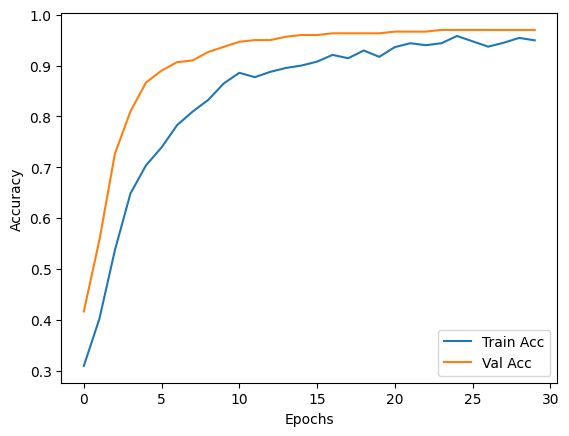

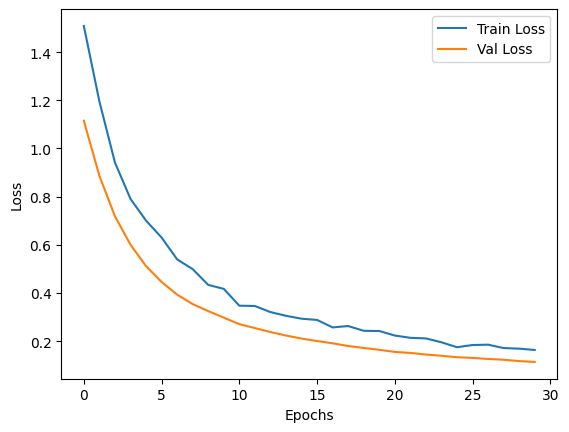

In [26]:
import matplotlib.pyplot as plt
import numpy as np

# Accuracy
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [25]:
y_true = []
y_pred_classes = []

for images, labels in test_ds:
    preds = model.predict(images)
    y_pred_classes.extend(np.argmax(preds, axis=1))
    y_true.extend(labels.numpy())

y_true = np.array(y_true)
y_pred_classes = np.array(y_pred_classes)

from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_true, y_pred_classes, target_names=class_names))

1/1 [==============================] - 0s 47ms/step
              precision    recall  f1-score   support

 Anthracnose       0.66      0.62      0.64        50
     Healthy       0.00      0.00      0.00        50
OtherDisease       0.38      0.79      0.51        48

    accuracy                           0.47       148
   macro avg       0.35      0.47      0.38       148
weighted avg       0.34      0.47      0.38       148



c:\Users\Jaero\anaconda3\envs\tf2.10-py310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Jaero\anaconda3\envs\tf2.10-py310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Jaero\anaconda3\envs\tf2.10-py310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


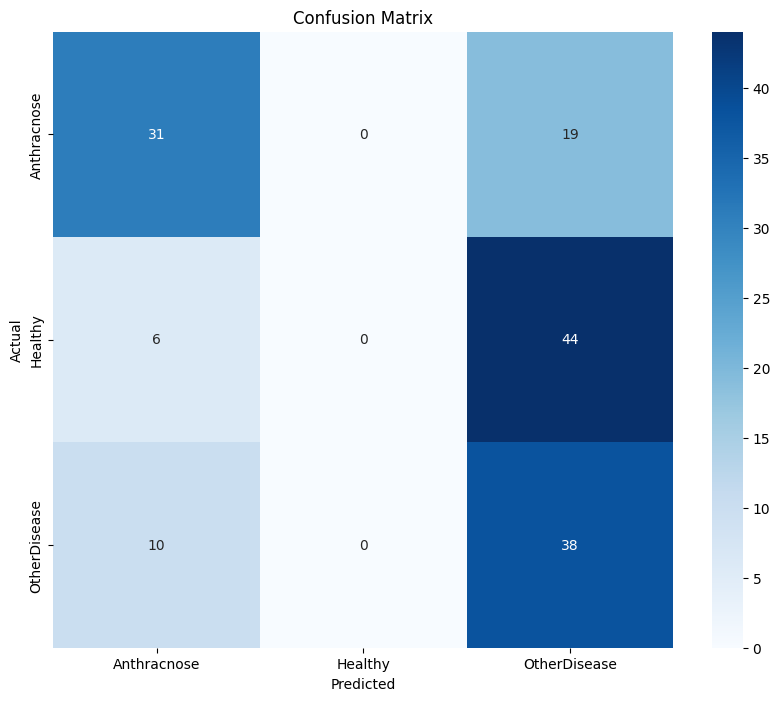

In [27]:
cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [11]:
for images, labels in test_ds.take(1):
    preds = np.argmax(model.predict(images), axis=1)
    print("Predicted:", preds)
    print("Actual   :", labels.numpy())

1/1 [==============================] - 0s 43ms/step
Predicted: [1 2 2 0 0 0 1 1 1 1 0 0 1 2 2 0 2 2 0 2 1 1 0 0 1 2 2 0 0 2 0 0]
Actual   : [1 2 2 0 0 0 1 1 1 1 0 0 1 0 2 0 2 2 0 2 1 1 0 0 1 2 2 0 0 2 0 0]


In [12]:
print(class_names)
print(model.output_shape)

['Anthracnose', 'Healthy', 'OtherDisease']
(None, 3)


In [13]:
# Old method
y_true_old = np.concatenate([y for x, y in test_ds], axis=0)
print("y_true_old shape:", y_true_old.shape)

# Correct method
y_true_new = []
for images, labels in test_ds:
    y_true_new.extend(labels.numpy())
y_true_new = np.array(y_true_new)
print("y_true_new shape:", y_true_new.shape)

y_true_old shape: (148,)
y_true_new shape: (148,)


## Model Saving and Export

This section demonstrates how to save the trained model for later use and optionally convert it to a lightweight format for deployment.

### Components

- **Saving the Keras Model**
  - `model.save("mango_leaf_disease_mobilenetv2.h5")`  
  - Saves the trained model in HDF5 (`.h5`) format.  
  - The saved model includes architecture, weights, and optimizer state, allowing it to be reloaded and used without retraining.  

- **TensorFlow Lite Conversion**
  - `tf.lite.TFLiteConverter.from_keras_model(model)` creates a converter to transform the model into TensorFlow Lite format.  
  - `converter.convert()` generates a `.tflite` version of the model.  
  - The converted model can be saved as a file (e.g., `mango_mobilenetv2.tflite`) and deployed to **mobile devices or edge hardware** such as Raspberry Pi, microcontrollers, or Android apps.  

### Purpose
- `.h5` model → for reuse in Python/TensorFlow environments.  
- `.tflite` model → for deployment in **resource-constrained devices**, enabling real-time inference on mobile or embedded systems.  


In [10]:

model.save("v1_mango_leaf_disease_mobilenetv2.h5")

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open("v1_mango_mobilenetv2.tflite", "wb") as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\Jaero\AppData\Local\Temp\tmpiwxafqvh\assets


INFO:tensorflow:Assets written to: C:\Users\Jaero\AppData\Local\Temp\tmpiwxafqvh\assets


In [7]:
from tensorflow.keras.models import load_model

test_model = load_model("../h5/v1_mango_leaf_disease_mobilenetv2.h5")  # or your SavedModel path

In [10]:
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=img_size,
    batch_size=batch_size,
)

def preprocess(images, labels):
    images = preprocess_input(images)  # Important for MobileNetV2
    return images, labels

class_names = test_ds.class_names
test_ds = test_ds.map(preprocess)

Found 148 files belonging to 3 classes.


In [11]:
y_true = []
y_pred_classes = []

for images, labels in test_ds:
    preds = test_model.predict(images)
    y_pred_classes.extend(np.argmax(preds, axis=1))
    y_true.extend(labels.numpy())

y_true = np.array(y_true)
y_pred_classes = np.array(y_pred_classes)

from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_true, y_pred_classes, target_names=class_names))

1/1 [==============================] - 0s 34ms/step
              precision    recall  f1-score   support

 Anthracnose       0.98      0.98      0.98        50
     Healthy       1.00      1.00      1.00        50
OtherDisease       0.98      0.98      0.98        48

    accuracy                           0.99       148
   macro avg       0.99      0.99      0.99       148
weighted avg       0.99      0.99      0.99       148

